# XGBoost regression

## Setup

In [1]:
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import xgboost as xgb
print("XGB Version:", xgb.__version__)

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV

XGB Version: 1.5.0


## Data

We use data drawn from the 1990 U.S. Census (see this [data description](https://developers.google.com/machine-learning/crash-course/california-housing-data-description) for more information).

### Data import

In [2]:
X, y = datasets.fetch_california_housing(return_X_y=True, as_frame=True) 

feature_names = X.columns

In [26]:
X.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB


In [27]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
MedInc,20640.0,3.870671,1.899822,0.499900,2.563400,3.534800,4.743250,15.000100
HouseAge,20640.0,28.639486,12.585558,1.000000,18.000000,29.000000,37.000000,52.000000
AveRooms,20640.0,5.429000,2.474173,0.846154,4.440716,5.229129,6.052381,141.909091
AveBedrms,20640.0,1.096675,0.473911,0.333333,1.006079,1.048780,1.099526,34.066667
Population,20640.0,1425.476744,1132.462122,3.000000,787.000000,1166.000000,1725.000000,35682.000000
AveOccup,20640.0,3.070655,10.386050,0.692308,2.429741,2.818116,3.282261,1243.333333
Latitude,20640.0,35.631861,2.135952,32.540000,33.930000,34.260000,37.710000,41.950000
Longitude,20640.0,-119.569704,2.003532,-124.350000,-121.800000,-118.490000,-118.010000,-114.310000


### Data splitting

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

## Model

It's also worth mentioning that though you are using trees as your base learners, you can also use XGBoost's relatively less popular linear base learners and one other tree learner known as dart. All you have to do is set the booster parameter to either gbtree (default),gblinear or dart.


### Hyperparameters

XGBoost provides many hyperparameters but we will only consider a few of them (see the [XGBoost documentation](https://xgboost.readthedocs.io/en/latest/parameter.html#general-parameters) for an complete overview). Note that we will use the [scikit-learn wrapper interface](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn):


- `objective`: determines the loss function to be used like `reg:squarederror` for regression problems, `binary:logistic` for logistic regression for binary classification or `multi:softmax`  to do multiclass classification using the softmax objectiv (note that there are more options).


- `n_estimators`: Number of gradient boosted trees. Equivalent to number of boosting rounds.


- `max_depth`: Maximum tree depth for base learners.


- `learning_rate`: Boosting learning rate (xgb’s “eta”). Range is [0,1]


- `subsample`: Subsample ratio of the training instance. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. 


- `colsample_bytree`: Subsample ratio of columns when constructing each tree. Subsampling occurs once for every tree constructed.


- `colsample_bylevel`: Subsample ratio of columns for each level. Subsampling occurs once for every new depth level reached in a tree. Columns are subsampled from the set of columns chosen for the current tree.


- `gamma`: Minimum loss reduction required to make a further partition on a leaf node of the tree. A higher value leads to fewer splits. 


- `reg_alpha`: L1 regularization term on weights (xgb’s alpha). A large value leads to more regularization.


- `reg_lambda`: L2 regularization term on weights (xgb’s lambda).

- `eval_metric` (default is according to objective). Evaluation metrics for validation data, a default metric will be assigned according to objective (`rmse` for regression, and `logloss` for classificationestimator
).


- `random_state`: Random number seed.

- `early_stopping_rounds`: If you have a validation set, you can use early stopping to find the optimal number of boosting rounds. Early stopping requires at least one set in evals. If there’s more than one, it will use the last. Note that we include this parameter in our fit function.


- Define hyperparameters

In [81]:
params = {
    "objective": "reg:squarederror",
    "n_estimators":10,
    "max_depth": 4,
    "learning_rate": 0.01,
    "subsample": 0.8,
    "colsample_bytree": 0.9,
    "colsample_bylevel": 0.8,
    "reg_lambda": 0.1,
    "eval_metric": "rmse",
    "random_state": 42,
}

### Evaluation set

- Prepare evaluation data:
  - If there’s more than one item in `eval_set`, the last entry will be used for early stopping.
  - If we want to plot the learning curves for both training and test data, we need to provide both training and test data as eval_set

In [15]:
eval_set = [(X_train, y_train), (X_test, y_test)]

### Fit model

In [79]:
reg = xgb.XGBRegressor(**params)

In [80]:
reg.fit(X_train, 
        y_train, 
        verbose=True,
        eval_set= eval_set,
        early_stopping_rounds= 5
        )

[16:25:53] WARNING: ../src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:1.93048	validation_1-rmse:1.93384
[1]	validation_0-rmse:1.91447	validation_1-rmse:1.91806
[2]	validation_0-rmse:1.89835	validation_1-rmse:1.90210
[3]	validation_0-rmse:1.88263	validation_1-rmse:1.88655
[4]	validation_0-rmse:1.86680	validation_1-rmse:1.87087
[5]	validation_0-rmse:1.85118	validation_1-rmse:1.85546
[6]	validation_0-rmse:1.83595	validation_1-rmse:1.84029
[7]	validation_0-rmse:1.82082	validation_1-rmse:1.82521
[8]	validation_0-rmse:1.80580	validation_1-rmse:1.81026
[9]	validation_0-rmse:1.79095	validation_1-rmse:1.79555
[10]	validation_0-rmse:1.77636	validation_1-rmse:1.78108
[11]	validation_0

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
             colsample_bynode=1, colsample_bytree=0.9, enable_categorical=False,
             eval_metric='rmse', gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=10,
             num_boost_round=10, num_parallel_tree=1, predictor='auto',
             random_state=42, reg_alpha=0, reg_lambda=0.1, scale_pos_weight=1,
             subsample=0.8, tree_method='exact', validate_parameters=1,
             verbosity=None)

### Evaluation

In [56]:
reg.evals_result()

{'validation_0': OrderedDict([('rmse',
               [1.930481,
                1.914465,
                1.898349,
                1.882632,
                1.866801,
                1.851181,
                1.835948,
                1.820825,
                1.805799,
                1.790947])]),
 'validation_1': OrderedDict([('rmse',
               [1.933837,
                1.918065,
                1.902101,
                1.886554,
                1.870871,
                1.855461,
                1.840294,
                1.825211,
                1.810264,
                1.795553])])}

- Next, we obtain our best iteration (this attribute is 0-based, for instance if the best iteration is the 5th round, then best_iteration is 4).

In [57]:
reg.best_iteration

9

- Make predictions

In [58]:
y_pred = reg.predict(X_test)

- Obtain RMSE

In [59]:
mean_squared_error(y_test, y_pred, squared = False)

1.7955535144593275

- Save the model

In [60]:
# Save model into JSON format.
reg.save_model("regressor.json")

### Plot training test deviance


- Obtain evaluation metrics

In [61]:
results = reg.evals_result()

- Plot training test deviance

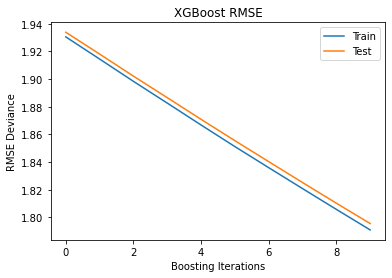

In [62]:
# Prepare x-axis
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()

ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')

plt.title('XGBoost RMSE')
plt.xlabel("Boosting Iterations")
plt.ylabel("RMSE Deviance")
plt.legend(loc="upper right");


## Feature importance

- Next, we take a look at the tree based feature importance and the permutation importance.

### Mean decrease in impurity (MDI)

- Mean decrease in impurity (MDI) is a measure of feature importance for decision tree models. 

```{Note}
Visit [this notebook](https://kirenz.github.io/feature-engineering/docs/mdi.html#) to learn more about MDI
```

In [63]:
reg.feature_importances_

array([0.47760484, 0.07838012, 0.17815246, 0.01194204, 0.01055134,
       0.12292594, 0.06152495, 0.05891829], dtype=float32)

- Feature importances are provided by the function `plot_importance` 

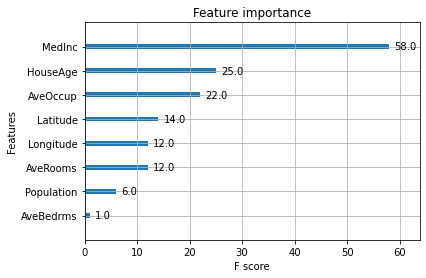

In [64]:
xgb.plot_importance(reg);

### Permutation feature importance

The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled. 

```{Note}
Visit [this notebook](https://kirenz.github.io/feature-engineering/docs/permutation-feature-importance.html) to learn more about permutation feature importance.
```

In [65]:

result = permutation_importance(
    reg, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

/Users/jankirenz/opt/anaconda3/envs/xgboost/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/jankirenz/opt/anaconda3/envs/xgboost/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [66]:
tree_importances = pd.Series(result.importances_mean, index=feature_names)

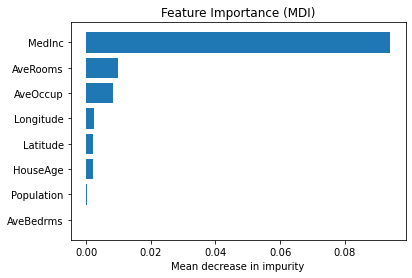

In [67]:
# sort features according to importance
sorted_idx = np.argsort(tree_importances)
pos = np.arange(sorted_idx.shape[0])

# plot feature importances
plt.barh(pos, tree_importances[sorted_idx], align="center")

plt.yticks(pos, np.array(feature_names)[sorted_idx])
plt.title("Feature Importance (MDI)")
plt.xlabel("Mean decrease in impurity");

- Same data plotted as boxplot:

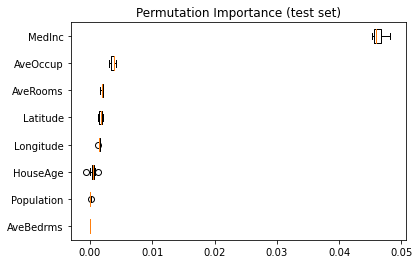

In [47]:
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names)[sorted_idx],
)

plt.title("Permutation Importance (test set)")
plt.show()

- We observe that the same features are detected as most important using both methods. Although the relative importances vary (especially for feature `Years`).

### Visualize tree

conda install -c anaconda graphviz


ImportError: You must install graphviz to plot tree

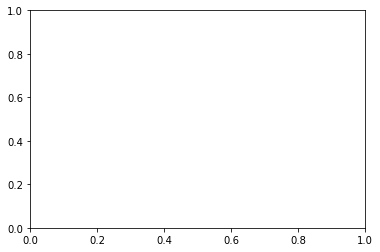

In [83]:
xgb.plot_tree(reg ,num_trees=0)

plt.rcParams['figure.figsize'] = [50, 10]
plt.show()

## Crossvalidation

In order to build more robust models, it is common to do a k-fold cross validation where all the entries in the original training dataset are used for both training as well as validation. Also, each entry is used for validation just once. 

First, we will convert the dataset into an optimized data structure called Dmatrix that XGBoost supports and gives it acclaimed performance and efficiency gains. 

In [70]:
dmatrix = xgb.DMatrix(data=X,label=y)


Almost the same hyperparameteras as before. We just drop num_estimators and instead use `num_boost_round`in fit.

In [87]:
params_cv = {
    "objective": "reg:squarederror",
    "max_depth": 4,
    "learning_rate": 0.01,
    "subsample": 0.8,
    "colsample_bytree": 0.9,
    "colsample_bylevel": 0.8,
    "reg_lambda": 0.1,
    "eval_metric": "rmse",
    "random_state": 42,
}

XGBoost supports k-fold cross validation via the cv() method. All you have to do is specify the nfolds parameter, which is the number of cross validation sets you want to build. 

In [88]:
reg_cv = xgb.cv(dtrain=dmatrix, 
                nfold=3,
                params=params_cv,
                num_boost_round=5,
                early_stopping_rounds=10,
                metrics="rmse", 
                as_pandas=True, 
                seed=123)

In [89]:
reg_cv.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,1.930837,0.008074,1.930872,0.016105
1,1.914908,0.008166,1.914989,0.015754
2,1.898777,0.008120,1.898905,0.015530
3,1.882705,0.008067,1.882887,0.015337
4,1.866842,0.007958,1.867077,0.015233


Extract and print the final boosting round metric.



In [76]:
print((reg_cv["test-rmse-mean"]).tail(1))

9    1.791268
Name: test-rmse-mean, dtype: float64


## Hyperparameter Tuning

In [50]:
params = { 'max_depth': [3,6],
           'learning_rate': [0.01, 0.05],
           'n_estimators': [10, 50],
           'colsample_bytree': [0.3, 0.7]}

In [51]:
xgbr = xgb.XGBRegressor(seed = 20)


In [52]:
clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=1)


In [53]:
clf.fit(X, y)


Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_esti...=None,
                                    num_parallel_tree=None, predictor=None,
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                    seed=

In [54]:
print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 50}
Lowest RMSE:  0.7115304756489487
